In [28]:
import pandas as pd
import numpy as np
import csv
import statsmodels.api as sm
import os

In [29]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import dotenv

# Load the environment variables
# (loads CENSUS_API_KEY from .env)
dotenv.load_dotenv()

False

In [31]:
%%R
library(tidyverse)

In [32]:
# Open the file and turn it into a pandas dataframe
df = pd.read_csv('Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

# Show the first 5 rows of the dataframe
print(df.head())

   RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     91982         1       77494        zip        TX    TX      Katy   
1     61148         2        8701        zip        NJ    NJ  Lakewood   
2     91940         3       77449        zip        TX    TX      Katy   
3     62080         4       11368        zip        NY    NY  New York   
4     91733         5       77084        zip        TX    TX   Houston   

                                   Metro        CountyName     2000-01-31  \
0   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  210077.000246   
1  New York-Newark-Jersey City, NY-NJ-PA      Ocean County  137227.265500   
2   Houston-The Woodlands-Sugar Land, TX     Harris County  103358.701090   
3  New York-Newark-Jersey City, NY-NJ-PA     Queens County  146558.052897   
4   Houston-The Woodlands-Sugar Land, TX     Harris County  102016.821579   

   ...     2023-05-31     2023-06-30     2023-07-31     2023-08-31  \
0  ...  474580.751007 

In [33]:
# Print the column names
print(df.columns)

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '2000-01-31',
       ...
       '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
       '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31', '2024-02-29'],
      dtype='object', length=299)


In [34]:
# Keep only data with State as NJ
df = df[df['State'] == 'NJ']

# Keep only columns including RegionName, StateName, City, Metro, CountyName, 31/12/2018, 31/12/2019, 31/12/2022, 31/12/2023
df = df[['RegionName', 'StateName', 'City', 'Metro', 'CountyName', '2018-12-31', '2019-12-31', '2022-12-31', '2023-12-31']]

In [35]:
# Ditch the rows with NaN values
df = df.dropna()

# Show how many rows are left
print(df.shape)

(544, 9)


In [36]:
df['RegionName'] = df['RegionName'].astype(str).str.zfill(5)

In [37]:
# Show the first 5 rows of RegionName
print(df['RegionName'].head())

1      08701
209    07055
218    07305
263    07087
337    08753
Name: RegionName, dtype: object


In [38]:
# Store all the RegionNames in a list
nj_zips = df['RegionName'].tolist()

In [39]:
%%R 

require('tidycensus')

# because it an environment variable, we don't have to 
# explicitly pass this string to R, it is readable here
# in this R cell.
census_api_key(Sys.getenv("97779d587a8fdba4e4f7f7d3eec838313d5b07ab"))

To install your API key for use in future sessions, run this function with `install = TRUE`.


In [40]:
%%R 
# Get variable from ACS
nj_census_data_2022 <- get_acs(geography = "zip code tabulation area",
                      variables = c(
                        total_population_2022 = "B01003_001",
                        median_room_2022 = "B25018_001",
                        median_built_2022 = "B25035_001",
                        median_income_2022 = "B06011_001",
                        bachelor_2022 = "B15003_022",
                        asian_2022 = "B03002_006", 
                        black_2022 = "B03002_004",
                        hispanic_2022 = "B03002_012"
                      ), 
                      year = 2022,
                      survey="acs5",
                      geometry=F)
nj_census_data_2022

# A tibble: 270,192 × 5
   GEOID NAME        variable              estimate   moe
   <chr> <chr>       <chr>                    <dbl> <dbl>
 1 00601 ZCTA5 00601 total_population_2022    16834   506
 2 00602 ZCTA5 00602 total_population_2022    37642   205
 3 00603 ZCTA5 00603 total_population_2022    49075   963
 4 00606 ZCTA5 00606 total_population_2022     5590   264
 5 00610 ZCTA5 00610 total_population_2022    25542   344
 6 00611 ZCTA5 00611 total_population_2022     1315   382
 7 00612 ZCTA5 00612 total_population_2022    63312  1805
 8 00616 ZCTA5 00616 total_population_2022     9625  1319
 9 00617 ZCTA5 00617 total_population_2022    22573   241
10 00622 ZCTA5 00622 total_population_2022     7577   979
# ℹ 270,182 more rows
# ℹ Use `print(n = ...)` to see more rows


Getting data from the 2018-2022 5-year ACS


In [41]:
%R -i nj_zips

nj_zips

['08701',
 '07055',
 '07305',
 '07087',
 '08753',
 '08854',
 '07093',
 '07047',
 '07002',
 '07111',
 '08527',
 '07728',
 '08861',
 '08901',
 '07083',
 '07306',
 '08873',
 '08831',
 '07470',
 '07104',
 '07105',
 '08540',
 '07030',
 '07003',
 '08081',
 '08302',
 '08816',
 '07052',
 '07302',
 '07304',
 '07060',
 '08021',
 '08053',
 '07960',
 '08817',
 '07601',
 '08234',
 '07202',
 '07036',
 '07726',
 '08054',
 '08360',
 '07032',
 '08844',
 '07307',
 '08080',
 '08902',
 '07107',
 '07666',
 '08857',
 '08820',
 '07011',
 '08094',
 '07731',
 '08724',
 '07712',
 '08807',
 '07024',
 '07017',
 '08401',
 '07109',
 '07753',
 '08012',
 '07103',
 '08618',
 '08759',
 '07501',
 '08096',
 '07106',
 '08332',
 '07410',
 '08016',
 '07050',
 '07208',
 '08723',
 '07026',
 '07747',
 '08610',
 '07740',
 '08520',
 '08046',
 '08648',
 '07039',
 '08003',
 '07090',
 '08043',
 '08822',
 '07013',
 '08757',
 '08865',
 '07018',
 '08611',
 '07840',
 '07110',
 '07065',
 '07054',
 '08075',
 '07631',
 '08330',
 '07201',


In [42]:
%%R
# Remove the "ZCTA5 " prefix from the NAME column
nj_census_data_2022$NAME <- sub("ZCTA5 ", "", nj_census_data_2022$NAME)

# Show the first 5 rows of the nj_census_data_2022 dataframe
head(nj_census_data_2022)

# A tibble: 6 × 5
  GEOID NAME  variable              estimate   moe
  <chr> <chr> <chr>                    <dbl> <dbl>
1 00601 00601 total_population_2022    16834   506
2 00602 00602 total_population_2022    37642   205
3 00603 00603 total_population_2022    49075   963
4 00606 00606 total_population_2022     5590   264
5 00610 00610 total_population_2022    25542   344
6 00611 00611 total_population_2022     1315   382


In [43]:
%%R
# Keep only the rows with RegionName in nj_zips
nj_census_data_2022 <- nj_census_data_2022[nj_census_data_2022$NAME %in% nj_zips,]

# Show the first 5 rows of the nj_census_data_2022 dataframe
head(nj_census_data_2022)

# A tibble: 6 × 5
  GEOID NAME  variable              estimate   moe
  <chr> <chr> <chr>                    <dbl> <dbl>
1 07001 07001 total_population_2022    17211  1059
2 07002 07002 total_population_2022    70497    71
3 07003 07003 total_population_2022    52594    98
4 07004 07004 total_population_2022     7723   293
5 07005 07005 total_population_2022    15106   402
6 07006 07006 total_population_2022    26449    65


In [44]:
%%R
# Ditch NAME and moe columns
nj_census_data_2022 <- nj_census_data_2022 %>%
  select(-NAME, -moe)

In [45]:
%%R
# Convert the long format to wide format
nj_census_data_2022_wide <- nj_census_data_2022 %>%
  pivot_wider(
    names_from = variable,  # Column that contains variable names
    values_from = estimate  # Column that contains the values
  )

# Show the first 5 rows of the nj_census_data_2022 dataframe
head(nj_census_data_2022_wide)

# A tibble: 6 × 9
  GEOID total_population_2022 median_room_2022 median_built_2022
  <chr>                 <dbl>            <dbl>             <dbl>
1 07001                 17211              4.4              1975
2 07002                 70497              4.6              1954
3 07003                 52594              5.1              1950
4 07004                  7723              7.5              1970
5 07005                 15106              6.7              1959
6 07006                 26449              7                1959
# ℹ 5 more variables: median_income_2022 <dbl>, bachelor_2022 <dbl>,
#   asian_2022 <dbl>, black_2022 <dbl>, hispanic_2022 <dbl>


In [46]:
%%R
df <- read.csv("Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")

# Fill the RegionName to 5 digits
df$RegionName <- as.character(df$RegionName)
df$RegionName <- sprintf("%05s", df$RegionName)

# Keep only data with State as NJ
df <- df[df$State == 'NJ',]

# Show the first 5 rows of the dataframe
head(df)

    RegionID SizeRank RegionName RegionType StateName State        City
2      61148        2      08701        zip        NJ    NJ    Lakewood
210    60565      215      07055        zip        NJ    NJ     Passaic
219    60642      224      07305        zip        NJ    NJ Jersey City
264    60594      269      07087        zip        NJ    NJ  Union City
338    61169      344      08753        zip        NJ    NJ  Toms River
411    61214      420      08854        zip        NJ    NJ  Piscataway
                                    Metro       CountyName X2000.01.31
2   New York-Newark-Jersey City, NY-NJ-PA     Ocean County   137227.27
210 New York-Newark-Jersey City, NY-NJ-PA   Passaic County   110925.69
219 New York-Newark-Jersey City, NY-NJ-PA    Hudson County   156415.28
264 New York-Newark-Jersey City, NY-NJ-PA    Hudson County    86110.22
338 New York-Newark-Jersey City, NY-NJ-PA     Ocean County   129265.97
411 New York-Newark-Jersey City, NY-NJ-PA Middlesex County   171447.76

In [47]:
%%R
# How many rows are left
nrow(df)

[1] 547


In [48]:
%%R

# Append the X2022.12.31 column to the ma_census_data_2022_wide dataframe
# With RegionName in df matching GEOID in ma_census_data_2022_wide. Only keep the rows with a match.

nj_census_data_2022_wide <- nj_census_data_2022_wide %>%
    inner_join(df, by = c('GEOID' = 'RegionName'))

# Show the first 5 rows of the nj_census_data_2022_wide dataframe
head(nj_census_data_2022_wide)

# A tibble: 6 × 307
  GEOID total_population_2022 median_room_2022 median_built_2022
  <chr>                 <dbl>            <dbl>             <dbl>
1 07001                 17211              4.4              1975
2 07002                 70497              4.6              1954
3 07003                 52594              5.1              1950
4 07004                  7723              7.5              1970
5 07005                 15106              6.7              1959
6 07006                 26449              7                1959
# ℹ 303 more variables: median_income_2022 <dbl>, bachelor_2022 <dbl>,
#   asian_2022 <dbl>, black_2022 <dbl>, hispanic_2022 <dbl>, RegionID <int>,
#   SizeRank <int>, RegionType <chr>, StateName <chr>, State <chr>, City <chr>,
#   Metro <chr>, CountyName <chr>, X2000.01.31 <dbl>, X2000.02.29 <dbl>,
#   X2000.03.31 <dbl>, X2000.04.30 <dbl>, X2000.05.31 <dbl>, X2000.06.30 <dbl>,
#   X2000.07.31 <dbl>, X2000.08.31 <dbl>, X2000.09.30 <dbl>, X2000.10.31 <dbl>,

In [49]:
%%R

# Create a new column named bachelor_rate_2022, which is the ratio of bachelor_2022 to total_population_2022
nj_census_data_2022_wide <- nj_census_data_2022_wide %>%
    mutate(bachelor_rate_2022 = bachelor_2022 / total_population_2022)

# Create a new column named asian_rate_2022, which is the ratio of asian_2022 to total_population_2022
nj_census_data_2022_wide <- nj_census_data_2022_wide %>%
    mutate(asian_rate_2022 = asian_2022 / total_population_2022)

# Create a new column named black_rate_2022, which is the ratio of black_2022 to total_population_2022
nj_census_data_2022_wide <- nj_census_data_2022_wide %>%
    mutate(black_rate_2022 = black_2022 / total_population_2022)

# Create a new column named hispanic_rate_2022, which is the ratio of hispanic_2022 to total_population_2022
nj_census_data_2022_wide <- nj_census_data_2022_wide %>%
    mutate(hispanic_rate_2022 = hispanic_2022 / total_population_2022)

In [50]:
%%R

# Create a new df, which includes the following columns from nj_census_data_2022_wide:
# GEOID, total_population_2022, median_room_2022, median_built_2022, median_income_2022, bachelor_rate_2022, asian_rate_2022, black_rate_2022, hispanic_rate_2022, X2022.12.31
df_final <- nj_census_data_2022_wide %>%
    select(GEOID, total_population_2022, median_room_2022, median_built_2022, median_income_2022, bachelor_rate_2022, asian_rate_2022, black_rate_2022, hispanic_rate_2022, X2022.12.31)

# Show the first 5 rows of the df_final dataframe
head(df_final)

# A tibble: 6 × 10
  GEOID total_population_2022 median_room_2022 median_built_2022
  <chr>                 <dbl>            <dbl>             <dbl>
1 07001                 17211              4.4              1975
2 07002                 70497              4.6              1954
3 07003                 52594              5.1              1950
4 07004                  7723              7.5              1970
5 07005                 15106              6.7              1959
6 07006                 26449              7                1959
# ℹ 6 more variables: median_income_2022 <dbl>, bachelor_rate_2022 <dbl>,
#   asian_rate_2022 <dbl>, black_rate_2022 <dbl>, hispanic_rate_2022 <dbl>,
#   X2022.12.31 <dbl>


In [51]:
%%R

# Run a multiple linear regression model with X2022.12.31 as the dependent variable
# and the other columns as the independent variables

model <- lm(X2022.12.31 ~ total_population_2022 + median_room_2022 + median_built_2022 + median_income_2022 + bachelor_rate_2022 + asian_rate_2022 + black_rate_2022 + hispanic_rate_2022, data = df_final)

# Show the summary of the model
summary(model)


Call:
lm(formula = X2022.12.31 ~ total_population_2022 + median_room_2022 + 
    median_built_2022 + median_income_2022 + bachelor_rate_2022 + 
    asian_rate_2022 + black_rate_2022 + hispanic_rate_2022, data = df_final)

Residuals:
    Min      1Q  Median      3Q     Max 
-376868 -125994  -46056   60985 2789886 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            4.165e+06  1.741e+06   2.392 0.017100 *  
total_population_2022 -6.855e-01  7.906e-01  -0.867 0.386283    
median_room_2022       6.330e+04  1.290e+04   4.908 1.22e-06 ***
median_built_2022     -2.376e+03  8.810e+02  -2.697 0.007224 ** 
median_income_2022     3.204e+00  1.114e+00   2.877 0.004178 ** 
bachelor_rate_2022     2.186e+06  2.465e+05   8.867  < 2e-16 ***
asian_rate_2022        4.968e+04  1.219e+05   0.408 0.683699    
black_rate_2022        9.413e+04  9.409e+04   1.000 0.317557    
hispanic_rate_2022     3.847e+05  9.916e+04   3.879 0.000118 ***
---
Signif. codes: 

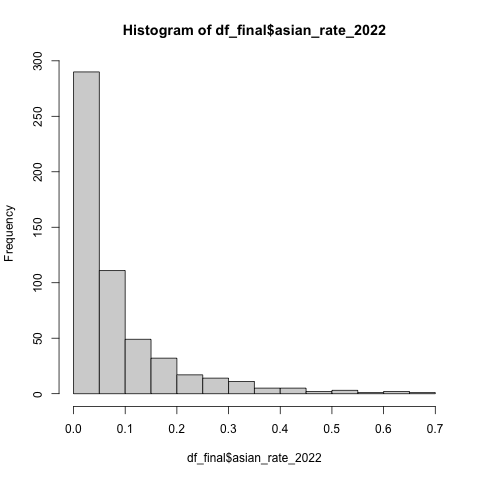

In [52]:
%%R

# Create a histogram of asian_rate_2022
hist(df_final$asian_rate_2022)